In [1]:
import numpy as np
from keras.models import Sequential
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation, Dropout
from keras.optimizers import Adam, SGD
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
NUMBER_OF_CLASSES = 100
epochs = 200
batch_size = 100
path_best = "gdrive/My Drive/Colab Notebooks/VGGNet16_ADAM_Dropout.h5"
# path_best = "../weights/VGGNet16_ADAM_Dropout.h5"
path_train = "gdrive/My Drive/Colab Notebooks/VGGNet16_ADAM_Dropout_2.h5" 

In [4]:
(x_train,y_train), (x_test, y_test) = cifar100.load_data()

y_train_norm = to_categorical(y_train, NUMBER_OF_CLASSES)
y_test_norm = to_categorical(y_test, NUMBER_OF_CLASSES)

y_test = y_test.flatten()

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

mean = np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))

x_train_norm = (x_train-mean)/(std+1e-7)
x_test_norm = (x_test-mean)/(std+1e-7)

169009152/169001437 [==============================] - 4s 0us/step


In [5]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

datagen.fit(x_train_norm)

In [6]:
def create_VGG16Model():
    model = Sequential()
    
    model.add(Conv2D(input_shape=(32,32,3), filters=64, kernel_size=(3,3), padding="same"))
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
    model.add(Activation('relu'))
    # model.add(Dropout(0.4))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
    model.add(Activation('relu'))
    
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    # model.add(Dropout(0.5))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
    model.add(Activation('relu'))
    # model.add(Dropout(0.7))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    # model.add(Dropout(0.7))
    model.add(Flatten())

    model.add(Dense(4096))
    model.add(Activation('relu'))
    # model.add(Dropout(0.7))
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # model.add(Dropout(0.7))
    model.add(Dense(NUMBER_OF_CLASSES))
    model.add(Activation('softmax'))
    return model

In [7]:
model = create_VGG16Model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 128)       0

In [8]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

**Training**

In [9]:
checkpoint = ModelCheckpoint(path_train, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [10]:
history = model.fit(datagen.flow(x_train_norm, y_train_norm,
                                        batch_size=batch_size),
                        steps_per_epoch=x_train_norm.shape[0]// batch_size,
                        epochs=epochs,
                        validation_data=(x_test_norm,y_test_norm),
                        callbacks=[checkpoint, early],verbose=2)

Epoch 1/200

Epoch 00001: val_accuracy improved from -inf to 0.01700, saving model to gdrive/My Drive/Colab Notebooks/VGGNet16_ADAM_Dropout_2.h5
500/500 - 38s - loss: 4.4206 - accuracy: 0.0197 - val_loss: 4.5056 - val_accuracy: 0.0170
Epoch 2/200

Epoch 00002: val_accuracy improved from 0.01700 to 0.03340, saving model to gdrive/My Drive/Colab Notebooks/VGGNet16_ADAM_Dropout_2.h5
500/500 - 37s - loss: 4.1640 - accuracy: 0.0373 - val_loss: 4.2572 - val_accuracy: 0.0334
Epoch 3/200

Epoch 00003: val_accuracy improved from 0.03340 to 0.05350, saving model to gdrive/My Drive/Colab Notebooks/VGGNet16_ADAM_Dropout_2.h5
500/500 - 36s - loss: 3.9986 - accuracy: 0.0580 - val_loss: 4.1362 - val_accuracy: 0.0535
Epoch 4/200

Epoch 00004: val_accuracy improved from 0.05350 to 0.07850, saving model to gdrive/My Drive/Colab Notebooks/VGGNet16_ADAM_Dropout_2.h5
500/500 - 36s - loss: 3.8325 - accuracy: 0.0859 - val_loss: 3.9851 - val_accuracy: 0.0785
Epoch 5/200

Epoch 00005: val_accuracy improved fro

*Plotting training accuracy and loss*

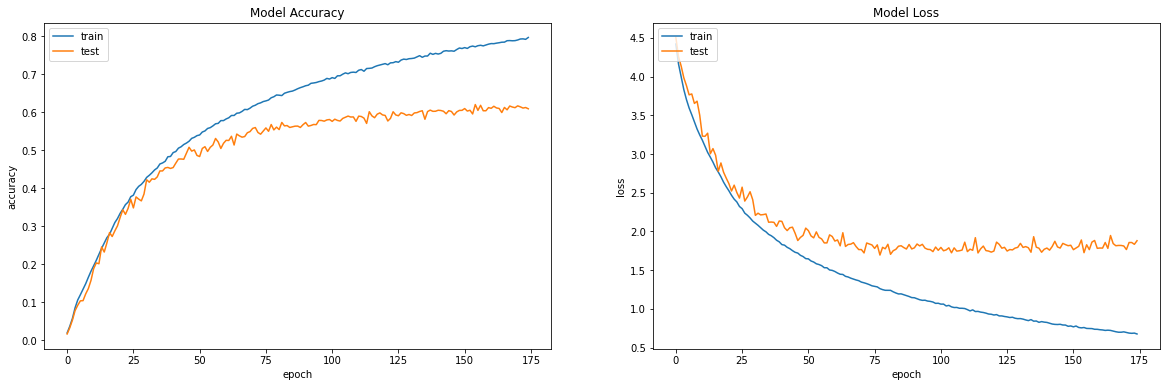

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set(ylabel ='accuracy')
axs[0].set(xlabel ='epoch')
axs[0].legend(['train', 'test'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set(ylabel='loss')
axs[1].set(xlabel='epoch')
axs[1].legend(['train', 'test'], loc='upper left')

**Prediction**

In [16]:
model.load_weights(path_best) 
y_pred = np.argmax(model.predict(x_test_norm), axis=-1)

In [17]:
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision: ", precision)
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall: ", recall)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Precision:  0.6329661774396537
Recall:  0.619
Accuracy:  0.619
